In [1]:
# import tensorflow.keras.layers as Layers
# import tensorflow.keras.activations as Actications
# import tensorflow.keras.models as Models
# import tensorflow.keras.optimizers as Optimizer
# import tensorflow.keras.metrics as Metrics
# import tensorflow.keras.utils as Utils
# from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec



import tensorflow as tf
import keras.backend.tensorflow_backend as ktf
import os
import sys

import keras
from keras.preprocessing import image
from keras.applications import imagenet_utils
from PIL import Image

from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout
from keras.applications import ResNet50, MobileNet, Xception
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger
from keras.regularizers import l2
from keras.initializers import he_normal

from keras.preprocessing.image import ImageDataGenerator
#from tqdm import tqdm
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for Building , 1 for forest, 2 for glacier, 3 for mountain, 4 for Sea , 5 for Street
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'glacier': #Folder contain Glacier Images get the '2' class label.
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label == 5
        elif labels == 'mountain':
            label = 3
        
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

In [3]:
Images, Labels = get_images('intel-image-classification/seg_train/') #Extract the training images from the folders.

Images = np.array(Images, np.float32) #converting the list of images to numpy array.
Labels = np.array(Labels, np.float32)


test_images,test_labels = get_images('intel-image-classification/seg_test/')
test_images = np.array(test_images, np.float32)
test_labels = np.array(test_labels, np.float32)

#print (test_labels.shape)
Labels = keras.utils.to_categorical(Labels, 6)
test_labels = keras.utils.to_categorical(test_labels, 6)

In [4]:
Epochs = 15
regularizer = 1e-5
batch_size = 32

In [5]:

def get_train_images():
    # reading the images
    import pandas as pd
    if not os.path.isfile('intel-image-classification/seg_train/'):
        train_img = []
        files = os.listdir('intel-image-classification/seg_train/')  # get all files in 'train' folder

        for img_path in tqdm(files):
        #img_path = 'train-00000.jpg'
        #for i in range(10):
            train_img.append(read_img_224('intel-image-classification/seg_train/' + img_path))
        X_train = np.array(train_img, np.float32)
        #pd.DataFrame(X_train).to_csv('train.csv', header=None, index=None)
        #np.save('train', X_train)
    #else:
        #X_train = np.genfromtxt('train.csv', delimiter=',')
        #X_train = np.load('train.npy')

    return X_train
#zz2 = get_train_images()
#print (zz2.shape)

In [6]:
def train_gen(x,y,batch_size=32):
    train_datagen = ImageDataGenerator(
        #rescale=1. / 255,
        rescale=None,
        shear_range=0.2,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

    #batch_size = 16
    train_generator = train_datagen.flow(x,y,32)
    return train_generator,len(x)

In [7]:
def train_aug_multitask(batch_size=32):
    #Images, Labels = get_images('intel-image-classification/seg_train/')
    #Images = np.array(Images) #converting the list of images to numpy array.
    #Labels = np.array(Labels)
    #temp1 = np.zeros((14034, 6))
    #for i in range(14034):
    #    for j in range(6):
     #       if j == Labels[i]:
       #         temp1[i][j] = 1
    x = Images
    y = Labels
    print(x.shape)
    print(y.shape)
    return train_gen(x, y, batch_size)

#zz = train_aug_multitask(batch_size=32)

In [8]:
checkpoint = ModelCheckpoint(filepath='weights.ep{epoch:02d}-loss{val_loss:.3f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [9]:
train_aug_gen, len_train = train_aug_multitask(batch_size=batch_size)

(14034, 224, 224, 3)
(14034, 6)


In [10]:
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3), pooling = 'avg')

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
features = base_model.output

In [12]:
# add a global spatial average pooling layer
#features = base_model.output

#print (features.shape)
#features = Dropout(0.5)(features)
#features = GlobalAveragePooling2D()(features)
# let's add a fully-connected layer
#features = Dense(2048, activation='relu')(features)
# and a logistic layer -- let's say we have 200 classes
#features = Dense(200, activation='relu')(features)

#predFC = Dense(6,activation='softmax', name='multi-labels', kernel_regularizer=l2(regularizer), bias_regularizer=l2(regularizer),kernel_initializer=he_normal())(features)
predFC = Dense(6,activation='softmax')(features)  
#final layer with softmax activation, output as probability


In [13]:
model = Model(inputs=base_model.input, outputs=predFC)
#model = base_model
#model.add(Layers.Flatten())

In [14]:
from keras.optimizers import SGD
#model.compile(optimizer = 'SGD', loss = 'binary_crossentropy', metrics= ['accuracy'], loss_weights = [2.0])
model.compile(optimizer = 'SGD', loss = 'categorical_crossentropy', metrics= ['accuracy'])

In [24]:
trained = model.fit_generator(train_aug_gen,
                        steps_per_epoch=len_train//batch_size,
                        validation_data=(test_images, test_labels),
                        epochs=Epochs, callbacks = [checkpoint, reduce_lr,early_stopping])

model.save('XC-3model.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
438/438 [==============================] - 166s 379ms/step - loss: 0.4011 - acc: 0.8487 - val_loss: 0.2588 - val_acc: 0.9093

Epoch 00001: val_loss improved from inf to 0.25877, saving model to weights.ep01-loss0.259.hdf5
Epoch 2/5
438/438 [==============================] - 162s 369ms/step - loss: 0.2636 - acc: 0.9067 - val_loss: 0.2225 - val_acc: 0.9130

Epoch 00002: val_loss improved from 0.25877 to 0.22249, saving model to weights.ep02-loss0.222.hdf5
Epoch 3/5
438/438 [==============================] - 162s 369ms/step - loss: 0.2129 - acc: 0.9227 - val_loss: 0.1976 - val_acc: 0.9320

Epoch 00003: val_loss improved from 0.22249 to 0.19757, saving model to weights.ep03-loss0.198.hdf5
Epoch 4/5
438/438 [==============================] - 161s 369ms/step - loss: 0.1915 - acc: 0.9307 - val_loss: 0.2229 - val_acc: 0.9253

Epoch 00004: val_loss did not improve from 0.19757
Epoch 5/5
438/438 [==============================] - 161s 369

In [ ]:
trained = model.fit(Images, Labels, epochs=Epochs, validation_split=0.30)
model.save('Xception_withoutDataAug_model.h5')

Instructions for updating:
Use tf.cast instead.
Train on 9823 samples, validate on 4211 samples
Epoch 1/15
9823/9823 [==============================] - 475s 48ms/step - loss: 0.7302 - acc: 0.7583 - val_loss: 0.3187 - val_acc: 0.8965
Epoch 2/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.2891 - acc: 0.9067 - val_loss: 0.2402 - val_acc: 0.9176
Epoch 3/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.2152 - acc: 0.9286 - val_loss: 0.2185 - val_acc: 0.9271
Epoch 4/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.1722 - acc: 0.9411 - val_loss: 0.2113 - val_acc: 0.9280
Epoch 5/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.1320 - acc: 0.9571 - val_loss: 0.2097 - val_acc: 0.9285
Epoch 6/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.1047 - acc: 0.9673 - val_loss: 0.2148 - val_acc: 0.9271
Epoch 7/15
9823/9823 [==============================] - 466s 47ms/step - loss: 0.0

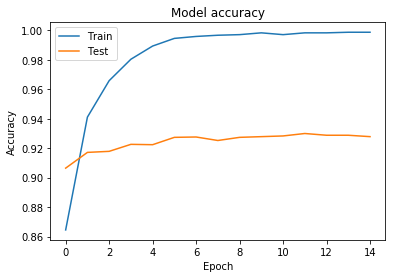

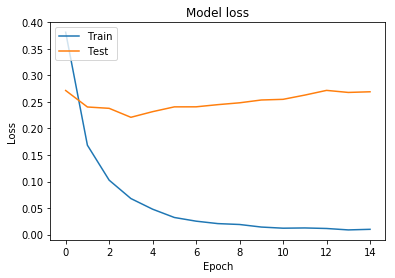

In [17]:
plot.plot(trained.history['acc'])
plot.plot(trained.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.savefig('Xception_withoutDataAug_TrainAcc')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.savefig('Xception_withoutDataAug_TrainLoss')
plot.show()

In [18]:
#test_images,test_labels = get_images('intel-image-classification/seg_test/')
#test_images = np.array(test_images)
#test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

3000/3000 [==============================] - 9s 3ms/step


[0.2436541570474704, 0.9313333331743876]